# Cargar librerias y datos

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

## Cargar datos de prueba: California Housing

**Si ya conoces este dataset puedes saltar esta parte**

Estos datos vienen en la mayoría de paquetes de Machine Learning, provienen de [Luís Torgo](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html) y StatLib.

La primera aparición de este dataset fue en 1997 en un paper titulado *Sparse Spatial Autoregressions by Pace, R. Kelley and Ronald Barry*. Lo crearon usando los datos del censo de 1990, contiene una fila por bloque de censo (esto típicamente tiene una población de 600 a 3000 personas)

In [2]:
X, y = fetch_california_housing(download_if_missing=True, return_X_y=True, as_frame=True)
X.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


Para ejemplificar el *split estratatificado*, miremos la columna *Median Income*

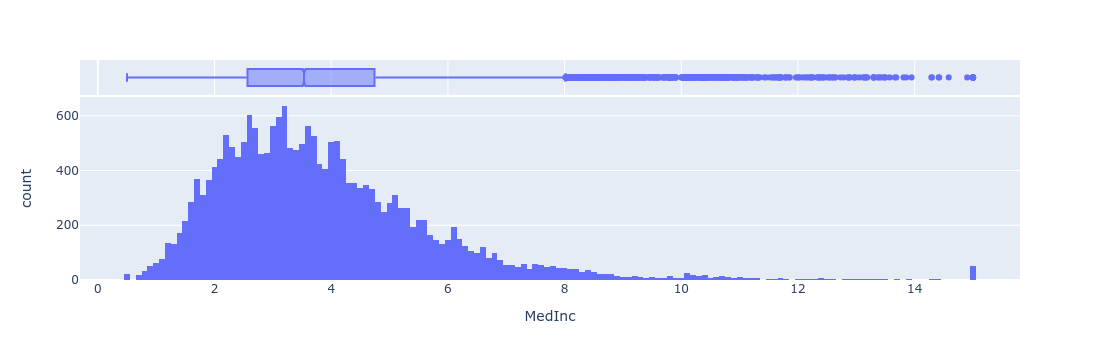

In [4]:
px.histogram(X, x="MedInc", marginal ="box")

La mayoría de los valores están entre 1.5 y 6. Crearemos bins a partir de esta feature de manera que éstos tengan suficiente cantidad de instancias

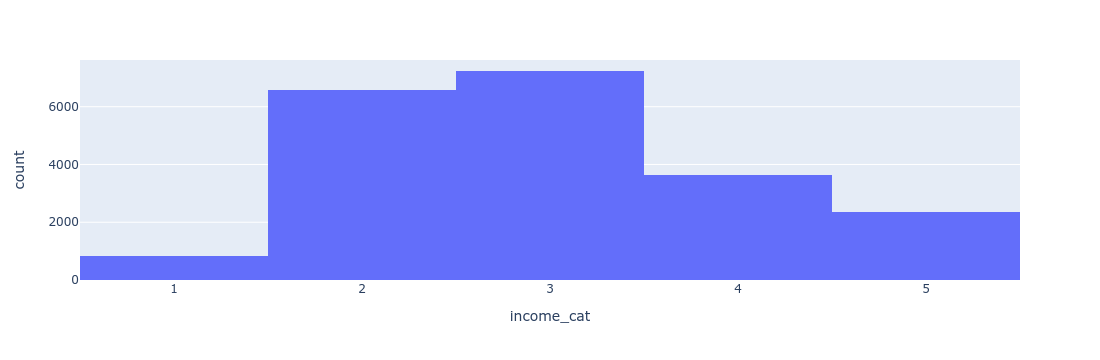

In [5]:
X["income_cat"] = pd.cut(X["MedInc"],
                                bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                labels=[1, 2, 3, 4, 5])

px.histogram(X, x = "income_cat")

Visualización densidad

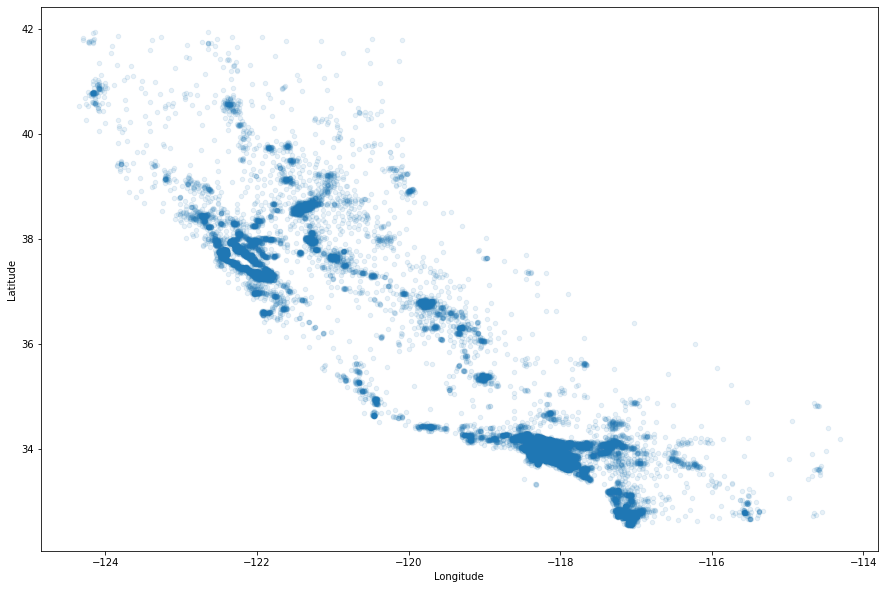

In [6]:
# alpha = 0.1 para poder apreciar zonas con mayor cantidad de casas
X.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.1, figsize = (15,10));

Notamos que las casas en zonas costeras y con alta densidad de población son más caras. De aquí que uno podría crear features relacionadas a esto.

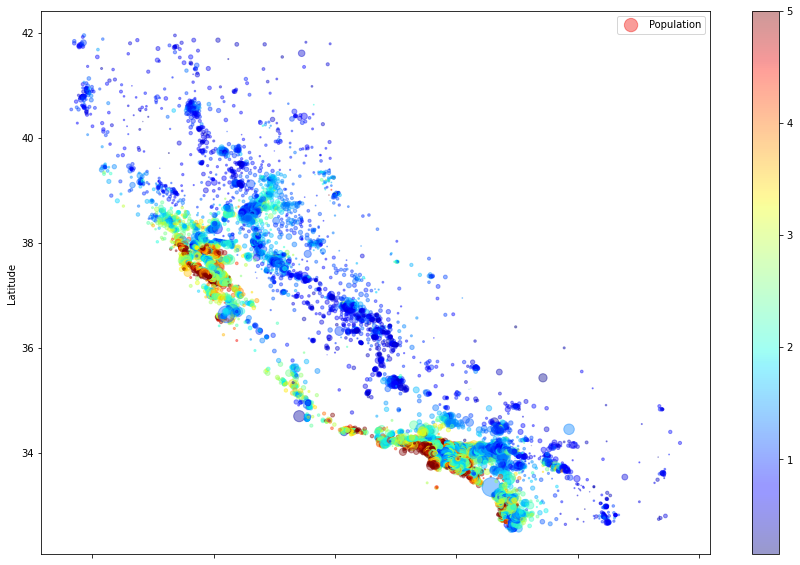

In [7]:
X.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4,
        s=X["Population"]/100, label="Population", figsize=(15,10),
        c=y, cmap=plt.get_cmap("jet"), colorbar=True,
        )
plt.legend();

# Validación de modelos

## Holdout

### Train Test Split

Este es el primer método que se enseña. Si bien es bueno para entender la idea.

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
train_set, y_train, test_set, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Existen otras formas de hacer un split por ejemplo ```StratifiedShuffle```

### StratifiedShuffleSplit

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, X["income_cat"]):
    strat_train_set = X.loc[train_index]
    y_train = y.loc[train_index]    
    strat_test_set = X.loc[test_index]
    y_test = y.loc[test_index]

In [11]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

### ¿Para qué nos sirve esto?

Tiene que ver con un concepto llamado ```Sampling Bias```, al hacer solo un split de manera aleatoria podemos tener casos en los que el train y test set no representan la realidad.

In [12]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(X, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "FullDataset": income_cat_proportions(X),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["FullDataset"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["FullDataset"] - 100

In [13]:
compare_props

FullDataset  Stratified    Random  Rand. %error  Strat. %error
1     0.039826    0.039729  0.040213      0.973236      -0.243309
2     0.318847    0.318798  0.324370      1.732260      -0.015195
3     0.350581    0.350533  0.358527      2.266446      -0.013820
4     0.176308    0.176357  0.167393     -5.056334       0.027480
5     0.114438    0.114583  0.109496     -4.318374       0.127011

El dataset generado utilizando random sampling es skewed.

## Cross-Validation

**cv:** int, cross-validation generator or an iterable, default=None
Determines the cross-validation splitting strategy. Possible inputs for cv are:

    - None, to use the default 5-fold cross validation,
    - int, to specify the number of folds in a (Stratified)KFold, CV splitter,
    - An iterable yielding (train, test) splits as arrays of indices.

For int/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. In all other cases, KFold is used. These splitters are instantiated with shuffle=False so the splits will be the same across calls.

[Ver más aquí](https://scikitlearn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [15]:
regr = RandomForestRegressor(max_depth=2, random_state=0, n_jobs = -1)
scores = cross_val_score(regr, X, y,
                        scoring="neg_mean_squared_error", cv=10)
rf_rmse_scores = np.sqrt(-scores)

In [16]:
def display_scores(scores):
    print("Scores:", scores.round(3))
    print("Mean:", scores.mean().round(3))
    print("Standard deviation:", scores.std().round(3))

display_scores(rf_rmse_scores)

Scores: [0.634 0.886 1.049 0.584 0.996 0.779 0.795 1.065 0.964 0.743]
Mean: 0.85
Standard deviation: 0.161


### Otras formas

Existen otras formas, pero básicamente con los conceptos anteriores se pueden derivar y modificar para crear la buena forma de hacer la separación entre datos de entrenamiento y datos de validación.

# Leaderboard Probing


Como vimos anteriormente, es importante que nuestro entorno local de validación sea lo más similar posible al real. En una competencia en Kaggle, nosotros no podemos ver todo el test set, un $70-80\%$ mantenece privado hasta finalizar la competencia. El porcentaje restante podemos verlo a partir de nuestro puntaje en Leaderboard, a partir de esto y la métrica de la competencia, nosotros podemos obtener información sobre los labels reales en test set.

Casos en donde esto es muy importante es cuando train y test set vienen de distintas distribuciones. En competencias pueden escribir en la descripción que train y test vienen de distintas distribuciones, otras veces la única forma es con EDA y Leaderboard Probing.

## Ejemplo: Predecir estatura de una persona

## Simular datos

Fuente: [Wikipedia](https://en.wikipedia.org/wiki/Human_body_weight)

In [17]:
sh = np.random.normal(169.6, 10.5, 1000)
sm = np.random.normal(156.1, 10, 1000)
hm = ["H"]*1000 + ["M"]*1000

In [18]:
df = pd.DataFrame( [np.concatenate([sh,sm]),  hm]).T
df.columns = ["Estatura", "S"]
df["Estatura"] = df["Estatura"].astype(float)

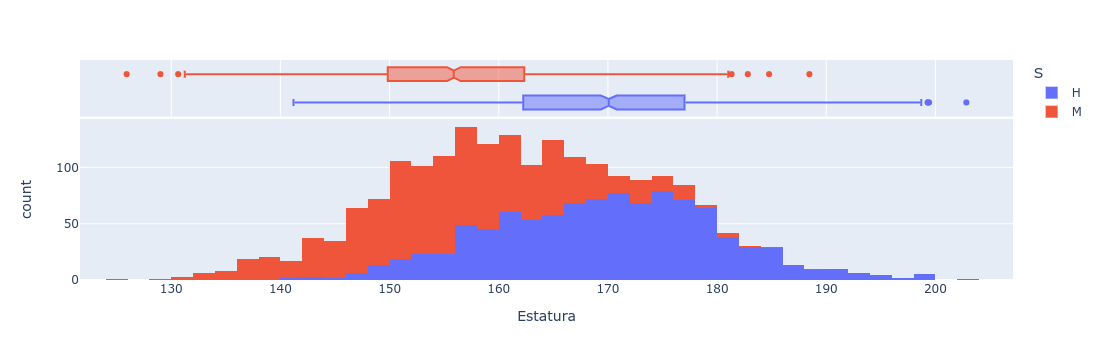

In [19]:
px.histogram(df, x="Estatura", color="S", marginal="box", hover_data=df.columns)

In [20]:
df.groupby("S").describe()

Estatura                                                             \
     count        mean        std         min         25%         50%   
S                                                                       
H   1000.0  169.740675  10.323175  141.197114  162.239447  170.081836   
M   1000.0  155.952754   9.658461  125.916812  149.831651  155.888896   

                           
          75%         max  
S                          
H  177.005901  202.832934  
M  162.321649  188.455477

In [21]:
# Simulemos como feature el peso promedio de hombres y mujeres
sh = np.random.normal(77.3, 6, 1000)
sm = np.random.normal(67.5, 5, 1000)
df.insert(1, "Peso", np.concatenate([sh,sm]))

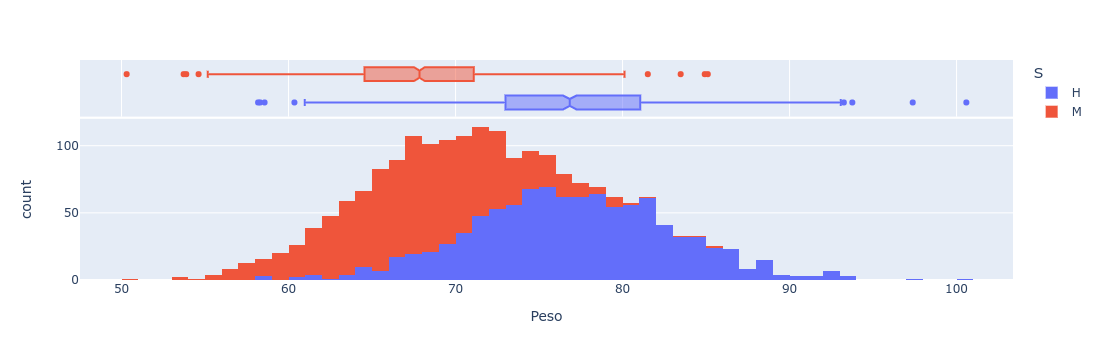

In [22]:
px.histogram(df, x="Peso", color="S", marginal="box", hover_data=df.columns)

## Train Set Mujeres, Test Set Hombres

In [23]:
train = df[df["S"] == "M"].copy()
test = df[df["S"] == "H"].copy() # Este es el test set en kaggle que no podemos ver

for _ in (train, test):
    _.drop(columns = "S", inplace = True)

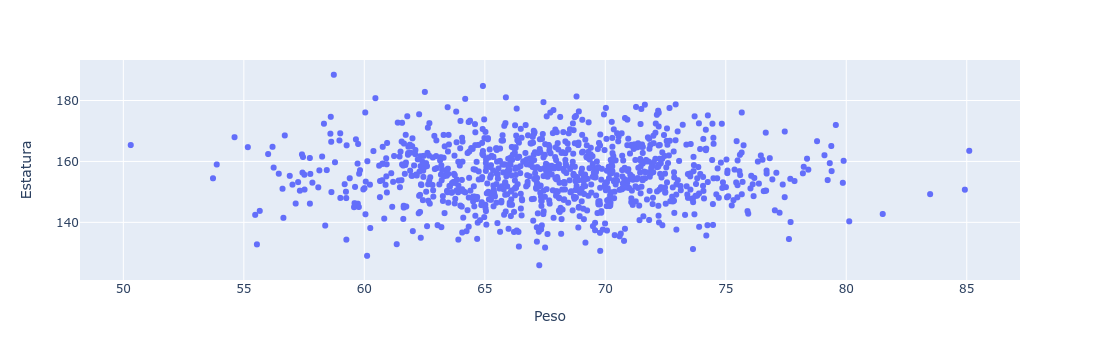

In [24]:
px.scatter(train, x = "Peso", y="Estatura")

In [25]:
X_train = train["Peso"].values.reshape(-1, 1)
y_train = train["Estatura"]

X_test = test["Peso"].values.reshape(-1, 1)
y_test = test["Estatura"]

Supongamos queremos utilizar una regresión lineal o un randomforest como baseline (normalmente tendremos más de una feature).

In [26]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
print("MSE:", mean_squared_error(y_test, reg.predict(X_test), squared = False))
print("MAE:", mean_absolute_error(y_test, reg.predict(X_test)))

MSE: 17.286855954467914
MAE: 14.672410380132016


In [27]:
rf = RandomForestRegressor().fit(X_train, y_train)
print("MSE:", mean_squared_error(y_test, rf.predict(X_test), squared = False))
print("MAE:", mean_absolute_error(y_test, rf.predict(X_test)))

MSE: 19.68377315220248
MAE: 16.571260800165803


Una regresión lineal sabe extrapolar resultados, sin embargo, del scatter plot se puede ver que no tenemos una relación lineal fuerte.
Por otro lado, modelos basados en árboles de decisión tienen la debilidad de ser malos extrapolando, en este caso, no nos daría valores más grandes
que la estatura de la mujer más grande.

In [28]:
shift_mse = (y_test.mean() - y_train.mean())
print(shift_mse)

13.78792101478544


In [29]:
lin_shift = mean_squared_error(y_test, reg.predict(X_test) + shift_mse, squared = False)
rf_shift = mean_squared_error(y_test, rf.predict(X_test) + shift_mse, squared = False)

print("Lin-Shift RMSE:", lin_shift.round(3), "RF-Shift RMSE:", rf_shift.round(3))

Lin-Shift RMSE: 10.319 RF-Shift RMSE: 12.467


Logramos mejorar los resultados considerablemente. La pregunta es ¿Cómo elegir el shift?

## Métrica competencia: MSE

Intentamos recuperar el promedio del test set utilizando leadearboard probing + fórmulas. Para luego hacer un shift en la diferencia de los promedios entre test y train.

¿Por qué el promedio?

Recordar la definición de MSE:
$$ 
MSE(y, \hat y) = \frac{1}{N} \sum_{i=1}^N (\hat y_i - y_i)^2
$$

Ahora, la pregunta es: Si las predicciones $\hat y_i$ son constantes e iguales a $\alpha$, $\hat y_i = \alpha$, que valor de  $\alpha$ mínimiza el error MSE? 

$$ 
\min_{\alpha} f(\alpha) = \frac{1}{N} \sum_{i=1}^N (\alpha - y_i)^2
$$

La función $f(\alpha)$, que queremos optimizar es suave con respecto a $\alpha$. Una condición necesaria para que $\alpha^*$ sea un mínimo local es: 
$$
\frac{d f}{d \alpha}\bigg|_{\alpha=\alpha^*} = 0\, .
$$

La gracia es que como la función es convexa, un mínimo local es también un mínimo global. Encontremos los puntos que cumplean tal condición:

$$
\frac{d f}{d \alpha}\bigg|_{\alpha=\alpha^*} = \frac{2}{N} \sum_{i=1}^N (\alpha^* - y_i) = 0
$$

$$
\frac{2}{N} \sum_{i=1}^N \alpha^* - \frac{2}{N} \sum_{i=1}^N y_i = 0
$$

$$
 \alpha^* - \frac{1}{N} \sum_{i=1}^N y_i = 0
$$

Finalmente:
$$
 \alpha^* =  \frac{1}{N} \sum_{i=1}^N y_i
$$

Dado que la segunda derivada $\frac{d^2 f}{d \alpha^2}$ es positiva en $\alpha^*$, lo que encontramos es un mínimo local.

### Ejemplo:

In [30]:
# Simulemos un valor target set
np.random.seed(42)
size = 100
target = np.random.randint(0, 30, size = size)
target.mean()

15.63

In [31]:
# Creamos una malla para buscar el mínimo numéricamente
alphas = np.linspace(0, 20, num= 2000)
df = pd.DataFrame(alphas, columns = ["Alpha"])

df["MSE"] = df["Alpha"].apply(lambda x: mean_squared_error(target, [x]*size))
df.loc[df["MSE"].argmin()]

Alpha    15.627814
MSE      80.793105
Name: 1562, dtype: float64

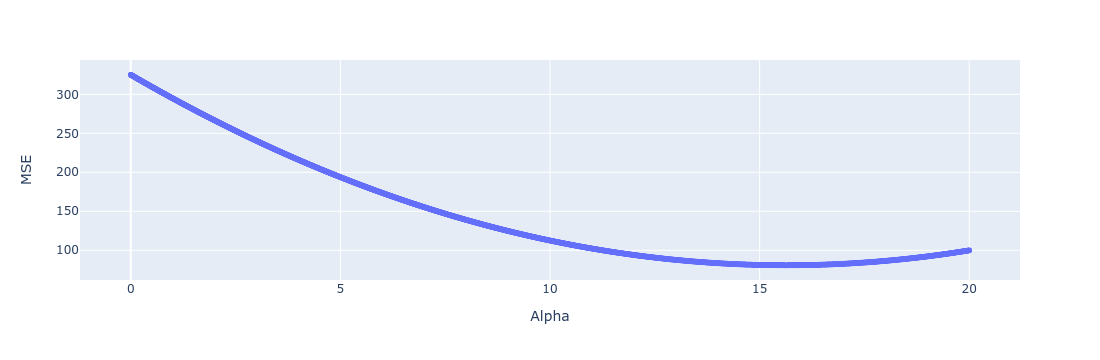

In [32]:
px.scatter(df, x="Alpha", y = "MSE")

## Métrica: MAE

La constante óptima es la mediana.

*Sketch of proof:*

$$ 
MAE(y, \hat y) = \frac{1}{N} \sum_{i=1}^N |\hat y_i - y_i|
$$

$$ 
\min_{\alpha} f(\alpha) = \frac{1}{N} \sum_{i=1}^N |\alpha - y_i|
$$

Recordar que $ \frac{\partial |x|}{dx} = sign(x)$, donde $sign$ es la [función signo](https://en.wikipedia.org/wiki/Sign_function) . Entonces


$$
\frac{d f}{d \alpha}\bigg|_{\alpha=\alpha^*} = \frac{1}{N} \sum_{i=1}^N sign(\alpha^* - y_i) = 0
$$

Tenemos que encontrar $\alpha^*$ tal que

$$
g(\alpha^*) = \sum_{i=1}^N sign(\alpha^* - y_i) = 0
$$

Notar que $g(\alpha^*)$ es una función constante por pedazos y no decreciente. $g(\alpha^*)=-1$ para todos los valores de $\alpha$ menores al mínimo $y_i$ y $g(\alpha^*)=1$ para $\alpha > \max_i y_i$. La función "salta"  $\frac{2}{N}$ en cada punto $y_i$. La siguiente imagen muestra la función para $y = [-0.5, 0, 1, 3, 3.4]$:

<div style="text-align:center">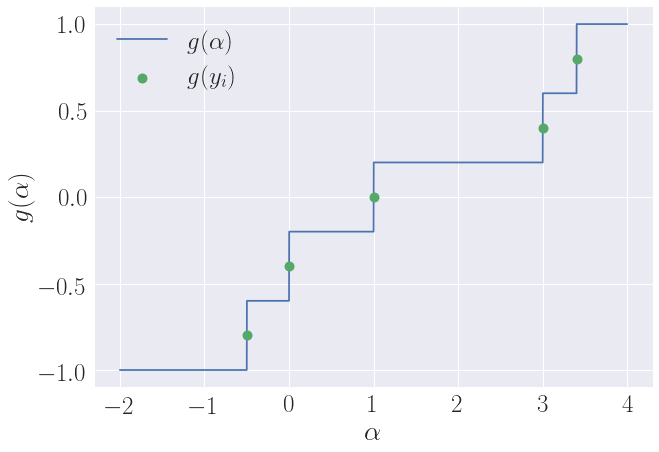</div>

Básicamente hay $N$ saltos del mismo porte, comenzando en $-1$ y terminando en $1$. Es claro que necesitamos $\frac{N}{2}$ saltos para llegar a 0. Esto pasa exactamente en la mediana del vector objetivo $g(median(y))=0$. Debemos ser cuídadosos y separar dos casos: Cuando hay un número par de puntos y cuando hay un número impar de puntos, pero la intuición es la misma.

In [33]:
# Siguiendo la simulación anterior
print("La mediana es", np.median(target))

La mediana es 17.0


Alpha    16.998499
MSE      82.665890
MAE       7.870030
Name: 1699, dtype: float64


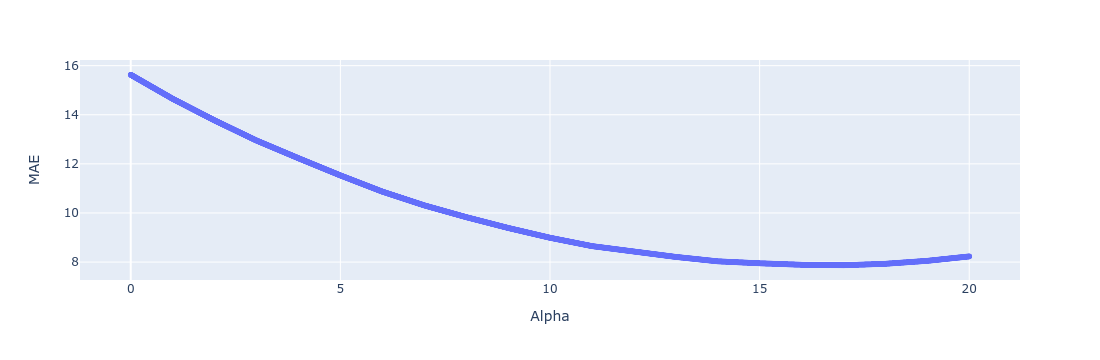

In [34]:
df["MAE"] = df["Alpha"].apply(lambda x: mean_absolute_error(target, [x]*size))
print(df.loc[df["MAE"].argmin()])
px.scatter(df, x="Alpha", y = "MAE")

# AutoML

Veremos lo siguiente: 

- Generación de modelos de alta performance [```h2o```](https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/intro.html)

Existen varias otras librerias que hacen lo mismo: Pycaret, TPOT, EvalML, Auto-Sklearn, entre otras.

La gracia de H2O es que crea modelos super complejos utilizando stacking (esto lo veremos en los siguientes meet-ups)

Inclusive, existen librerias open source que generan features de manera automatica: ```featuretools```

## H2o

In [35]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.11" 2021-04-20; OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.20.04); OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.20.04, mixed mode, sharing)
  Starting server from /home/daniel/miniconda3/envs/datascience/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp0dpead27
  JVM stdout: /tmp/tmp0dpead27/h2o_daniel_started_from_python.out
  JVM stderr: /tmp/tmp0dpead27/h2o_daniel_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O_cluster_uptime:         01 secs
H2O_cluster_timezone:       America/Santiago
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.32.1.5
H2O_cluster_version_age:    11 days
H2O_cluster_name:           H2O_from_python_daniel_8eemj9
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    11.77 Gb
H2O_cluster_total_cores:    16
H2O_cluster_allowed_cores:  16
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.8.10 final
--------------------------  ------------------------------------------------------------------

In [36]:
for train_index, test_index in split.split(X, X["income_cat"]):
    strat_train_set = X.loc[train_index]
    y_train = y.loc[train_index]    
    strat_test_set = X.loc[test_index]
    y_test = y.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

train = pd.concat([strat_train_set, y_train], axis = 1)
test = pd.concat([strat_test_set, y_test], axis = 1)

In [37]:
hf_train = h2o.H2OFrame(train)
hf_test = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [38]:
response = "MedHouseVal"
columnas = hf_train.columns
columnas.remove(response)

In [39]:
# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
# Lo dejamos en 60 segundos
aml = H2OAutoML(max_runtime_secs = 60, seed = 42)
aml.train(x = columnas, 
          y = response ,
          training_frame = hf_train,
          leaderboard_frame = hf_test)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [40]:
lb = aml.leaderboard
lb

model_id mean_residual_deviance rmse mse mae rmsle 
 
 
 StackedEnsemble_AllModels_AutoML_20210815_194242 0.197456 0.44436 0.197456 0.297434 0.135226 
 StackedEnsemble_BestOfFamily_AutoML_20210815_194242 0.199409 0.446552 0.199409 0.299235 0.136148 
 GBM_4_AutoML_20210815_194242 0.2097 0.45793 0.2097 0.309674 0.139308 
 GBM_3_AutoML_20210815_194242 0.212675 0.461167 0.212675 0.311516 0.140406 
 XGBoost_grid__1_AutoML_20210815_194242_model_1 0.21479 0.463455 0.21479 0.31933 0.144147 
 GBM_5_AutoML_20210815_194242 0.221817 0.470975 0.221817 0.318958 0.14357 
 GBM_2_AutoML_20210815_194242 0.230726 0.480339 0.230726 0.330456 0.146851 
 XGBoost_grid__1_AutoML_20210815_194242_model_2 0.233913 0.483646 0.233913 0.333152 0.148301 
 XGBoost_3_AutoML_20210815_194242 0.245324 0.495302 0.245324 0.341924 0.152988 
 XGBoost_2_AutoML_20210815_194242 0.246277 0.496263 0.246277 0.336412 0.15084

In [41]:
# Recuperar lider
leader_model = aml.leader
leader_model

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20210815_194242

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.1110611791370436
RMSE: 0.33325842695578395
MAE: 0.22336287438343608
RMSLE: 0.09996059916655874
R^2: 0.9177370902338141
Mean Residual Deviance: 0.1110611791370436
Null degrees of freedom: 10005
Residual degrees of freedom: 9997
Null deviance: 13508.96413494632
Residual deviance: 1111.2781584452582
AIC: 6425.871221017555

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.2163881896118011
RMSE: 0.46517543960510327
MAE: 0.30455197013695257
RMSLE: 0.13887609946240284
R^2: 0.8383519372585599
Mean Residual Deviance: 0.2163881896118011
Null degrees of freedom: 16511
Residual degrees of freedom: 16502
Null deviance: 22109.84651515388
Residual deviance: 3573.0017868700597
AIC: 21606.416327281106


In [42]:
# Comparemos contra la performance de un RandomForest
rf = RandomForestRegressor()
rf.fit(strat_train_set, y_train)
preds = rf.predict(strat_test_set)
mse, mae = mean_squared_error(preds, y_test),  mean_absolute_error(preds, y_test)
print("MSE: ", mse, "MAE:", mae)

MSE:  0.2447203213477647 MAE: 0.3264164055959304


Notamos que hay una mejora no menor proporcionada por el Emsemble de H2O

In [43]:
# Predicciones en test data
hf_test_predict = leader_model.predict(hf_test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


Podemos ver más información sobre el modelo ganador.

Vemos que es un stacking utilizando GB como metamodelo con los siguientes modelos base:

In [44]:
leader_model.base_models

['GBM_4_AutoML_20210815_194242',
 'GBM_3_AutoML_20210815_194242',
 'XGBoost_grid__1_AutoML_20210815_194242_model_1',
 'GBM_5_AutoML_20210815_194242',
 'GBM_2_AutoML_20210815_194242',
 'XGBoost_grid__1_AutoML_20210815_194242_model_2',
 'XGBoost_3_AutoML_20210815_194242',
 'XGBoost_2_AutoML_20210815_194242',
 'GBM_grid__1_AutoML_20210815_194242_model_1',
 'GBM_grid__1_AutoML_20210815_194242_model_2',
 'XGBoost_1_AutoML_20210815_194242',
 'XRT_1_AutoML_20210815_194242',
 'DeepLearning_grid__2_AutoML_20210815_194242_model_2',
 'DeepLearning_grid__1_AutoML_20210815_194242_model_2',
 'GBM_1_AutoML_20210815_194242',
 'DeepLearning_1_AutoML_20210815_194242',
 'DeepLearning_grid__1_AutoML_20210815_194242_model_1',
 'GLM_1_AutoML_20210815_194242',
 'DeepLearning_grid__3_AutoML_20210815_194242_model_2',
 'DRF_1_AutoML_20210815_194242',
 'DeepLearning_grid__3_AutoML_20210815_194242_model_1',
 'DeepLearning_grid__2_AutoML_20210815_194242_model_1',
 'GBM_grid__1_AutoML_20210815_194242_model_3']

In [45]:
leader_model.actual_params

{'model_id': 'StackedEnsemble_AllModels_AutoML_20210815_194242',
 'training_frame': 'automl_training_Key_Frame__upload_acadab804ea5b7706570a771896d410e.hex',
 'response_column': 'MedHouseVal',
 'validation_frame': None,
 'blending_frame': None,
 'base_models': [{'__meta': {'schema_version': 3,
    'schema_name': 'KeyV3',
    'schema_type': 'Key<Keyed>'},
   'name': 'GBM_4_AutoML_20210815_194242',
   'type': 'Key<Keyed>',
   'URL': None},
  {'__meta': {'schema_version': 3,
    'schema_name': 'KeyV3',
    'schema_type': 'Key<Keyed>'},
   'name': 'GBM_3_AutoML_20210815_194242',
   'type': 'Key<Keyed>',
   'URL': None},
  {'__meta': {'schema_version': 3,
    'schema_name': 'KeyV3',
    'schema_type': 'Key<Keyed>'},
   'name': 'XGBoost_grid__1_AutoML_20210815_194242_model_1',
   'type': 'Key<Keyed>',
   'URL': None},
  {'__meta': {'schema_version': 3,
    'schema_name': 'KeyV3',
    'schema_type': 'Key<Keyed>'},
   'name': 'GBM_5_AutoML_20210815_194242',
   'type': 'Key<Keyed>',
   'URL': N

In [46]:
h2o.cluster().shutdown()

H2O session _sid_8d59 closed.
